# Asymptotic Consistency

The purpose of this script is exploring the asymptotic behaviour of the method

In [26]:
# scripts and libraries
remove(list = ls())
options(warn = -1)
library(ggpattern)
library(data.table)
library(magrittr)
library(ggplot2)
library(latex2exp)
library(xtable)

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

We set the corresponding parameters

In [27]:
m <- 11 # series' dimension
r <- 9 # stable space's dimension
S <- 500 # number of simulation
crit <- "SC(n)" # criterio Johansen estimation
ec_det <- "none" # non trend and seasonality for Johansen procedure
pct <- "5pct" # Johansen's significance level
test <- "kpss" # test to use in PLS o PCA options: "adf" and "kpss"
persistence <- "low" ; dist <- "normal" # persistence and innovation process distribution
dependence <- TRUE
methods_colors <- c("PLS" = "#56B4E9", "PCA" = "#009E73") 
methods_pattern <- c("PLS" = "stripe", "PCA" = "crosshatch")

The following function conducts a simulation study for analizing the asymptotic behaviour of 
$$ T\lVert P_{\beta_{\perp}}\hat{\beta}_{\text{PLS}} \rVert$$

In [28]:
norm_beta <- function(seeds,Tt,S,m,r){
    sample_norm_PLS <- c()
    sample_norm_PCA <- c()
    dist <- "normal" ; persistence <- "low"
    # Shared Sigma_eps
    set.seed(seeds[1])  # for reproducibility
    if (dependence) {
    Sigma_eps <- clusterGeneration::genPositiveDefMat(m, covMethod = "eigen")$Sigma
    } else {
    Sigma_eps <- sigma * diag(1, m, m)
    }

    # Shared stable basis
    set.seed(seeds[2])  # shared seed for beta, beta_orto, alpha, gamma
    I_m <- qr.Q(qr(matrix(rnorm(m^2), m, m)))
    beta <- I_m[, 1:r]
    beta_orto <- if (r < m) I_m[, (r + 1):m] else matrix(0, m, m)

    # Alpha and gamma
    alpha <- if (persistence == "low") runif(r, 0.1, 0.3) else runif(r, 0.3, 0.7)
    gamma <- runif(ncol(beta_orto), -0.7, 0.7)

    for(s in 1:S){
        X <- X_simulation(seed = s,
                        m = m, r = r, Tt = Tt + 100,
                        beta = beta, beta_orto = beta_orto,
                        alpha = alpha, gamma = gamma, Sigma_eps = Sigma_eps,dist = dist)

        beta_teo <- as.matrix(X$beta) ; beta_teo_orto <- as.matrix(X$beta_orto)
        P_beta <- beta_teo%*%solve(t(beta_teo)%*%beta_teo)%*%t(beta_teo)
        P_beta_orto <- beta_teo_orto%*%solve(t(beta_teo_orto)%*%beta_teo_orto)%*%t(beta_teo_orto)
    
        X <- ts(scale(X$X[101:nrow(X$X), ],scale=FALSE))

        # PLS
        basis_PLS <- pls_alg(X) ; beta_PLS <- basis_PLS$PLS_w[,(m-r+1):m]
        sample_norm_PLS <- c(sample_norm_PLS,Tt*norm(P_beta_orto%*%beta_PLS))

        # PCA
        basis_PCA <- pca_alg(X) ; beta_PCA <- basis_PCA[,(m-r+1):m]
        sample_norm_PCA <- c(sample_norm_PCA,Tt*norm(P_beta_orto%*%beta_PCA))
        
    }
    return(data.frame(T=Tt, PLS=sample_norm_PLS, PCA=sample_norm_PCA))
}

We visualize the convergence

In [29]:
Tts <- seq(50,200,by = 50) # sequence of lengths

sim_results <- do.call("rbind",lapply(Tts,norm_beta,seeds = c(12,1123),S=S,m=m,r=r))%>% tidyr::pivot_longer(-T,names_to = "Estimator",
                                                                    values_to = "estimate") 

And obtain the plot

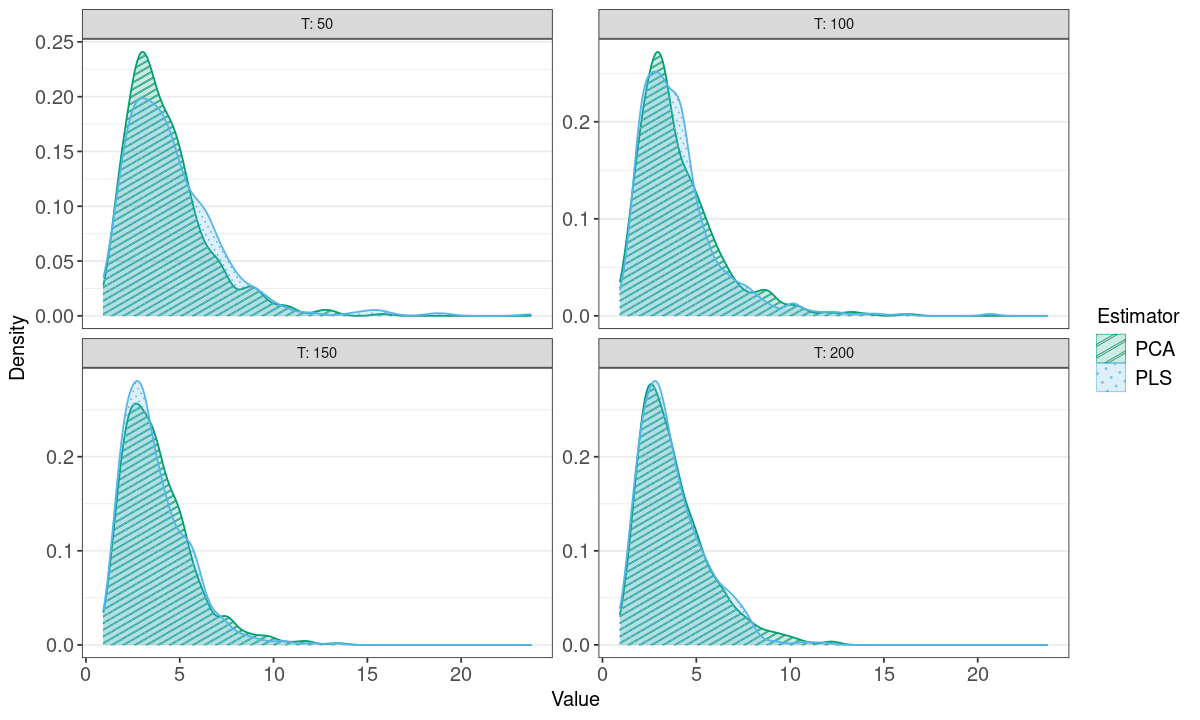

In [36]:
ggplot(sim_results, aes(x = estimate, color = Estimator, fill = Estimator, pattern = Estimator,
                        pattern_colour = Estimator)) +
  facet_wrap(~T, ncol = 2, scales = "free_y", labeller = "label_both") +
  geom_density_pattern(
    alpha = 0.2,
    pattern_spacing = 0.02,   # tighter spacing = thinner feel
    pattern_size = 0.2        # thinner pattern lines
  ) +
  labs(x = "Value", y = "Density") +
  theme(legend.position = "bottom") + 
  mytheme +
  scale_fill_manual(values = methods_colors) +
  scale_color_manual(values = methods_colors) +
  scale_pattern_fill_manual(values = methods_pattern) +
  scale_pattern_colour_manual(values = methods_colors)  # This is the key addition
